# MLP Implementation by numpy

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
#Import data
def load_data():
    df = pd.read_csv('./task1.csv',index_col=0)
    train_set, test_set = train_test_split(df, test_size=0.15, shuffle=True)    #data divide

    #train
    X_train = train_set.values[:,:2]
    #y_train = np.array([train_set.values[:,2]]).T
    profession = train_set.values[:,2]
    profession_enc = preprocessing.LabelEncoder().fit_transform(profession).reshape(-1,1)
    y_train = OneHotEncoder().fit_transform(profession_enc).toarray()   #one-hot vectorize

    #test
    X_test = test_set.values[:,:2]
    #y_test = np.array([test_set.values[:,2]]).T
    profession = test_set.values[:,2]
    profession_enc = preprocessing.LabelEncoder().fit_transform(profession).reshape(-1,1)
    y_test = OneHotEncoder().fit_transform(profession_enc).toarray()    #one-hot vectorize


    #print(len(X_train), len(y_train))
    #print(len(X_test), len(y_test))

    return X_train, y_train, X_test, y_test

In [3]:
# create network (very noisy...)
class MLP():
    def __init__(self, input_units, hidden1_units, hidden2_units, output_units):
        self.W1 = np.random.randn(input_units, hidden1_units)
        self.b1 = np.random.randn(1, hidden1_units)
        self.W2 = np.random.randn(hidden1_units, hidden2_units)
        self.b2 = np.random.randn(1, hidden2_units)
        self.W3 = np.random.randn(hidden2_units, output_units)
        self.b3 = np.random.randn(1, output_units)

    #シグモイド関数
    def sigmoid(self, x):
        y = 1 / (1 + np.exp(-x))
        return y
    #シグモイド関数の微分
    def sigmoid_det(self, x):
        y = self.sigmoid(x) * (1 - self.sigmoid(x))
        return y

    #tanh
    def tanh(self,x):
        return np.tanh(x)
    #tanhの微分
    def tanh_det(self,x):
        return 1.0-self.tanh(x)*self.tanh(x)

    #ランプ関数
    def relu(self,x):
        return x * (x > 0)
    #ランプ関数の微分
    def relu_det(self,x):
        return 1.0 * (x > 0)

    #L2正則化
    def _L2_reg(self, lamda, w1, w2, m):
        """Compute L2-regularization cost"""
        #loss = (lamda/2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))
        loss = (np.sum(np.square(w1)) + np.sum(np.square(w2)))*(lamda/(2*m))
        return loss

    #交差エントロピー
    def cross_entropy(self, t, y, m):
        """cross_entropy function
        t: target
        y: predict
        m: size of data array
        """
        delta = 1e-7
        y_soft = self.softmax(y)
        cost = - np.sum(t * np.log(y_soft + delta) + (1 - t) * np.log(1 - y_soft + delta)) / m
        #cost = - np.sum(t_label * np.log(y_label + delta)
        return cost

    #ソフトマックス関数
    def softmax(self,a):
        c = np.max(a)
        exp_a = np.exp(a - c)
        sum_exp_a = np.sum(exp_a)
        y = exp_a / sum_exp_a
        return y

    #予測精度計算
    def accuracy(self, X, t):
        result = np.where(np.argmax(t, axis=1)==np.argmax(X, axis=1), 1, 0)
        acc = np.mean(result)
        return acc

    #トレーニング
    def train(self, X_train, y_train, epochs, learning_rate, dropout_rate, lamda):
        #print("pre_train:",self.W1,self.W2)
        loss = []
        acc_list = []

        print('Training...')
        for i in range(epochs+1):

            m = X_train.shape[0]
            #順伝播・フォワードプロパゲーション・Forward-Propagation
            layer_z1 = np.dot(X_train, self.W1) + self.b1
            layer_a1 = self.tanh(layer_z1)
            layer_z1 *= np.random.binomial([np.ones((len(X_train), len(self.W2)))],\
                    1-dropout_rate)[0] * (1.0/(1-dropout_rate)) #Dropout

            layer_z2 = np.dot(layer_a1, self.W2) + self.b2
            layer_a2 = self.tanh(layer_z2)
            #layer_a2 *= np.random.binomial([np.ones((len(layer_a1), len(self.W3)))],\
            #        1-dropout_rate)[0] * (1.0/(1-dropout_rate))    #Dropout

            layer_z3 = np.dot(layer_a2, self.W3)  + self.b3
            layer_a3 = layer_z3 #最終出力は活性化関数を通さない(恒等関数)
            #layer_a3 *= np.random.binomial([np.ones((len(layer_a2), 3))],\
            #        1-dropout_rate)[0] * (1.0/(1-dropout_rate))    #Dropout

            #Back-Propagation
            dlayer_z3 = (layer_a3 - y_train)/m
            dW3 = np.dot(layer_a2.T, dlayer_z3)
            db3 = np.sum(dlayer_z3, axis=0 ,keepdims=True)

            dlayer_z2 = np.dot(dlayer_z3, self.W3.T) * self.tanh_det(layer_z2)
            dW2 = np.dot(layer_a1.T, dlayer_z2)
            db2 = np.sum(dlayer_z2, axis=0, keepdims=True)

            dlayer_z1 = np.dot(dlayer_z2, self.W2.T) * self.tanh_det(layer_z1)
            dW1 = np.dot(X_train.T, dlayer_z1)
            db1 = np.sum(dlayer_z1, axis=0 ,keepdims=True)

            #パラメータ更新
            #層ごとに学習率を変化させる
            lr1 = learning_rate
            lr2 = learning_rate * 0.1
            lr3 = learning_rate * 0.01

            """
            self.W3 -= learning_rate * dW3
            self.b3 -= learning_rate * db3
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1"""

            self.W3 -= lr3 * dW3
            self.b3 -= lr3 * db3
            self.W2 -= lr2 * dW2
            self.b2 -= lr2 * db2
            self.W1 -= lr1 * dW1
            self.b1 -= lr1 * db1

            #loss function
            cost = self.cross_entropy(y_train,layer_a3, m)  #cross_entropy
            cost += self._L2_reg(lamda, self.W2, self.W3, m)#L2 loss
            cost += self._L2_reg(lamda, self.W1, self.W2, m)
            #cost += (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))*(lamda/(2*m))
            #cost += (np.sum(np.square(self.W2)) + np.sum(np.square(self.W2)))*(lamda/(2*m))

            loss.append(cost)
            acc = self.accuracy(layer_a3, y_train)
            acc_list.append(acc)
            if i % 1000 == 0:
                print("epoch",i,"| acc:", acc_list[-1] ,"\tloss:", loss[-1])

        #print("trained:",self.W1,self.W2)
        return layer_a3, loss, acc_list

    #テスト関数
    def test(self, X_test):
        layer_z1 = np.dot(X_test, self.W1) + self.b1
        layer_a1 = self.tanh(layer_z1)
        layer_z2 = np.dot(layer_a1, self.W2) + self.b2
        layer_a2 = self.tanh(layer_z2)
        layer_z3 = np.dot(layer_a2, self.W3) + self.b3
        layer_a3 = layer_z3
        #print("test:",self.W1,self.W2)

        return layer_a3

In [4]:
#Data preparation
X_train, y_train, X_test, y_test = load_data()

#create MLP network
input_units, hidden1_units, hidden2_units, output_units = (2,20,10,3)#ユニットサイズ

#Hyper parameters
epochs =10000
learning_rate = 1
lamda = 0.01   #weight decay
dropout_rate = 0.2

#model training
mlp = MLP(input_units, hidden1_units, hidden2_units, output_units) #make instance
_, loss, acc = mlp.train(X_train, y_train, epochs, learning_rate, dropout_rate, lamda) #training

predict = mlp.test(X_test)  #test
#print(predict)
#print(y_test)
final_acc = mlp.accuracy(predict, y_test)   #final accuracy
print("test acc:",final_acc)

Training...
epoch 0 | acc: 0.40705882352941175 	loss: 13.122194521797253
epoch 1000 | acc: 0.9380392156862745 	loss: 10.126019284032477
epoch 2000 | acc: 0.9484705882352941 	loss: 10.07003260952334
epoch 3000 | acc: 0.9488627450980393 	loss: 10.068951106948063
epoch 4000 | acc: 0.9490196078431372 	loss: 10.069511948672238
epoch 5000 | acc: 0.9492549019607843 	loss: 10.0699793219941
epoch 6000 | acc: 0.9491764705882353 	loss: 10.070340467215983
epoch 7000 | acc: 0.9493333333333334 	loss: 10.070640622911867
epoch 8000 | acc: 0.9492549019607843 	loss: 10.070994820332059
epoch 9000 | acc: 0.9493333333333334 	loss: 10.07104932404699
epoch 10000 | acc: 0.9495686274509804 	loss: 10.07120315126
test acc: 0.9515555555555556


In [5]:
y_t = np.argmax(y_test, axis=1)
y_p = np.argmax(predict, axis=1)
    
#print classification report
print(classification_report(np.hstack(y_t), np.hstack(y_p)))
print("accuracy:", accuracy_score(y_t, y_p))
print("confusion_matrix\n",confusion_matrix(y_t, y_p))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97       746
          1       0.91      0.94      0.93       721
          2       0.97      0.95      0.96       783

avg / total       0.95      0.95      0.95      2250

accuracy: 0.9515555555555556
confusion_matrix
 [[721  25   0]
 [ 20 678  23]
 [  2  39 742]]


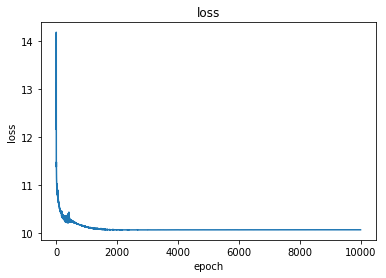

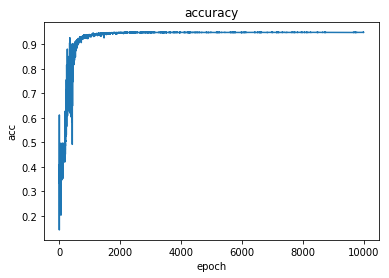

In [7]:
#drow loss & accuracy curve
import matplotlib.pyplot as plt
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss)
plt.show()

plt.title("accuracy")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.plot(acc)
plt.show()